# Save and load TDS results

This note book is used to demonstrate the function to export TDS results as CSV file, and plot the resuls from saved files.

## Run TDS

In [1]:
import os

import andes

In [2]:
print(andes.__version__)

1.7.0.post6.dev0+g62253ba4


In [3]:
ss = andes.load(andes.get_case('ieee14/ieee14_ac8b.xlsx'), no_output=True, setup=False)

In [4]:
ss.setup()

True

In [5]:
ss.PFlow.run()

True

Set the end time as 50 and run TDS

In [6]:
ss.TDS.config.tf = 50
ss.TDS.run()

/Users/jinningwang/.andes/pycode/AC8B.py:121: RuntimeWarning: invalid value encountered in sqrt
  return array([[FEX_y*INT_y - vf0], [-FEX_y + select([less_equal(IN, 0),less_equal(IN, 0.433),less_equal(IN, 0.75),less_equal(IN, 1),greater(IN, 1),__trues], [__ones,1 - 0.577*IN,sqrt(0.75 - IN**2),1.732 - 1.732*IN,__zeros,__zeros], default=nan)], [-IN*INT_y + KC*XadIfd]])
/Users/jinningwang/.andes/pycode/AC8B.py:125: RuntimeWarning: invalid value encountered in sqrt
  return array([[FEX_y, INT_y, 0], [0, -1, select([less_equal(IN, 0),less_equal(IN, 0.433),less_equal(IN, 0.75),less_equal(IN, 1),__trues], [__zeros,-0.577*__ones,-IN/sqrt(0.75 - IN**2),-1.732*__ones,__zeros], default=nan)], [-IN, 0, -INT_y]])


  0%|          | 0/100 [00:00<?, ?%/s]

<Toggler Toggler_1>: Line.Line_1 status changed to 0 at t=1.0 sec.
<Toggler Toggler_2>: Line.Line_1 status changed to 1 at t=1.1 sec.


True

Export TDS results as CSV file

In [7]:
ss.TDS.plt.export_csv()

## Load results

Load another system from the same case

In [8]:
ssf = andes.load(andes.get_case('ieee14/ieee14_ac8b.xlsx'), no_output=True)

Set the TDS loading from CSV

In [9]:
ssf.TDS.from_csv = 'ieee14_ac8b_out.csv'

In [10]:
ssf.PFlow.run()

True

In [11]:
ssf.TDS.run()

/Users/jinningwang/.andes/pycode/AC8B.py:121: RuntimeWarning: invalid value encountered in sqrt
  return array([[FEX_y*INT_y - vf0], [-FEX_y + select([less_equal(IN, 0),less_equal(IN, 0.433),less_equal(IN, 0.75),less_equal(IN, 1),greater(IN, 1),__trues], [__ones,1 - 0.577*IN,sqrt(0.75 - IN**2),1.732 - 1.732*IN,__zeros,__zeros], default=nan)], [-IN*INT_y + KC*XadIfd]])
/Users/jinningwang/.andes/pycode/AC8B.py:125: RuntimeWarning: invalid value encountered in sqrt
  return array([[FEX_y, INT_y, 0], [0, -1, select([less_equal(IN, 0),less_equal(IN, 0.433),less_equal(IN, 0.75),less_equal(IN, 1),__trues], [__zeros,-0.577*__ones,-IN/sqrt(0.75 - IN**2),-1.732*__ones,__zeros], default=nan)], [-IN, 0, -INT_y]])


  0%|          | 0/100 [00:00<?, ?%/s]

True

The results are from the CSV file.

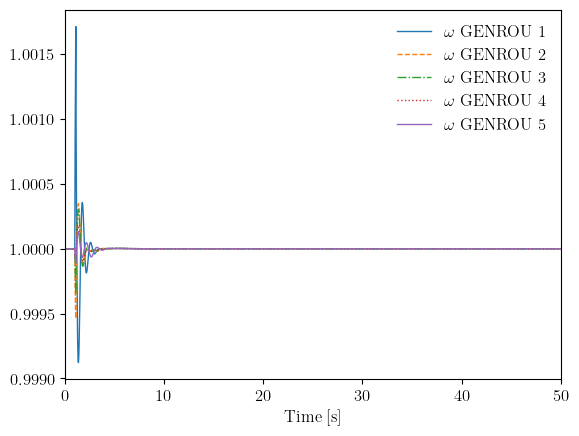

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [12]:
ssf.TDS.plt.plot(ssf.GENROU.omega)

Remove the CSV file

In [13]:
os.remove('ieee14_ac8b_out.csv')